In [9]:
# add the main directory to the path
import sys
sys.path.append("..")

import logging
import time
import pandas as pd
import numpy as np
import tqdm
from scipy.optimize import minimize_scalar
import seaborn as sns
import matplotlib.pyplot as plt
from model_no_gams.model import get_profiles_shares

In [2]:
fn_renewable: str = "../data/renewables_ninja.parquet"
fn_demand: str = "../data/renewables_with_load.parquet"

In [3]:
# country = "DE"
# year_re = 2019
# year_dem = 2019
# df_shares = get_profiles_shares(
#     country=country,
#     year_re=year_re,
#     year_dem=year_dem,
#     fn_renewable=fn_renewable,
#     fn_demand=fn_demand
# )
# df_total = get_data_by_years(
#     country=country,
#     year_re=year_re,
#     year_dem=year_dem,
#     fn_renewable=fn_renewable,
#     fn_demand=fn_demand
# )
# df_total.corr()
# df_shares.corr()

In [4]:
def calculate_storage_need(
        df_profiles: pd.DataFrame,
        share_renewable: float, 
        share_wind: float=0.5, 
        total_demand: float=100) -> pd.DataFrame:
    """Calculate the maximum storage needed for a given share of wind power.
    
    Args:
        df_profiles (pd.DataFrame): The profiles of the demand, pv, wind, and base load.
        share_renewable (float): The share of renewable energy in total demand
        share_wind (float): The share of wind energy in the renewable energy.
        total_demand (float): The total demand in the system.
    
    Returns:
        pd.DataFrame: production and storage schedule.
    """
    df = df_profiles.assign(
        demand=lambda df: df["demand"] * total_demand,
        pv=lambda df: df["pv"] * share_renewable * (1-share_wind) * total_demand,
        wind=lambda df: df["wind"] * share_renewable * share_wind * total_demand,
        base=lambda df: df["base"] * (1-share_renewable) * total_demand,
        supply=lambda df: df["pv"] + df["wind"] + df["base"],
        netSupply=lambda df: df["supply"] - df["demand"],
        cumSupply=lambda df: df["netSupply"].cumsum(),
        # initial storage level is the minimum of the cumSupply to ensure
        # that net supply is never negative
        initialStorageLevel=lambda df: -df.cumSupply.min(),
        storageLevel=lambda df: df["cumSupply"] + df["initialStorageLevel"],
        MAX_STO=lambda df: df["storageLevel"].max(),
        shareWind=share_wind,
        renewableDemandShare=share_renewable
    )
    return df.drop(columns=["cumSupply"])

def optimize_storage_need(
        df_profiles: pd.DataFrame,
        share_renewable: float, 
        total_demand: float=100) -> float:
    """Calculate the maximum storage needed for a given share of wind power.

    Args:.
        df_profiles (pd.DataFrame): The profiles of the demand, pv, wind, and base load.
        share_renewable (float): The share of renewable energy in total demand
        total_demand (float): The total demand in the system.
    
    Returns:
        float: maximum storage need
    """
    def optimize_me(share_wind):
        df = calculate_storage_need(
            df_profiles=df_profiles,
            share_renewable=share_renewable,
            share_wind=share_wind,
            total_demand=total_demand
        )
        return df["MAX_STO"].iloc[-1]
    #return optimize_me(share_wind=0.5)
    initial_value = 0.5 
    bounds = [0, 1] 
    result = minimize_scalar(
        optimize_me, 
        initial_value, 
        args=(),
        bounds=bounds
    )
    if not result.success:
        return None
    # compute the final schedule
    df = calculate_storage_need(
        df_profiles=df_profiles,
        share_renewable=share_renewable,
        share_wind=result.x,
        total_demand=total_demand
    )
    return df
    
def simulate_storage_need(
    country:str,
    year_re:int,
    year_dem:int,
    share_renewable:float,
    total_demand:float = 100,
    fn_renewable:str = "../data/renewables_ninja.parquet",
    fn_demand:str = "../data/renewables_with_load.parquet"
):
    # get the profile data
    df_shares = get_profiles_shares(
        country=country,
        year_re=year_re,
        year_dem=year_dem,
        fn_renewable=fn_renewable,
        fn_demand=fn_demand
    )
    # optimize the storage need
    df_opt = optimize_storage_need(
        df_profiles=df_shares,
        share_renewable=share_renewable,
        total_demand=total_demand
    )
    if df_opt is None:
        logging.error(f"Optimization failed for country {country} and weather year {year_re} and demand year {year_dem}")
        return None
    return df_opt

def simulate_storage_need_by_years(
    countries: list[str],
    shares_renewable: list[float],
    years_re: list[int],
    years_dem: list[int],
    fn_renewable: str = "../data/renewables_ninja.parquet",
    fn_demand: str = "../data/renewables_with_load.parquet",
) -> pd.DataFrame:
    """Simulate storage need for several countries and years optimizing
    over the share of wind power"""
    tic = time.time()
    all_combis = [
        (c, sr, y1, y2)
        for c in countries
        for sr in shares_renewable
        for y1 in years_re
        for y2 in years_dem
    ]
    lst_df = []
    failed = 0
    for country, share_renewable, year_re, year_dem in tqdm.tqdm(all_combis):
        df_ = simulate_storage_need(
            country=country,
            year_re=year_re,
            year_dem=year_dem,
            share_renewable=share_renewable,
            fn_renewable=fn_renewable,
            fn_demand=fn_demand
        )
        if df_ is not None:
            lst_df.append(df_.assign(
                country=country,
                yearWeather=year_re,
                yearDemand=year_dem,
                renewableDemandShare=share_renewable,
            ))
        else:
            failed += 1
    df_out = pd.concat(lst_df)
    print(f"Solve {len(all_combis)} scenarios in : {time.time() - tic:.2f} seconds.")
    print(f"Failed to solve {failed} of {len(all_combis)} scenarios")
    return df_out

In [5]:
countries = ["DE", "FR", "GR"]
years_re = range(1980, 2020)
years_dem = range(2015, 2024)
steps = 10
shares_renewable = list(np.linspace(0, 1, steps + 1))

df_out = simulate_storage_need_by_years(
    countries=countries,
    shares_renewable=shares_renewable,
    years_re=years_re,
    years_dem=years_dem,
    fn_renewable=fn_renewable,
    fn_demand=fn_demand
)

100%|██████████| 11880/11880 [17:25<00:00, 11.37it/s]


Solve 11880 scenarios in : 1047.07 seconds.
Failed to solve 0 of 11880 scenarios


In [6]:
df_out.to_parquet("../results/results_no_gams.parquet")

## Plot results

In [8]:
df_agg = (
    df_out
    .groupby(["country", "renewableDemandShare", "yearWeather", "yearDemand"], as_index=False)
    [["MAX_STO", "shareWind"]]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["shareWind"] * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int)
    )
    .round(2)
)

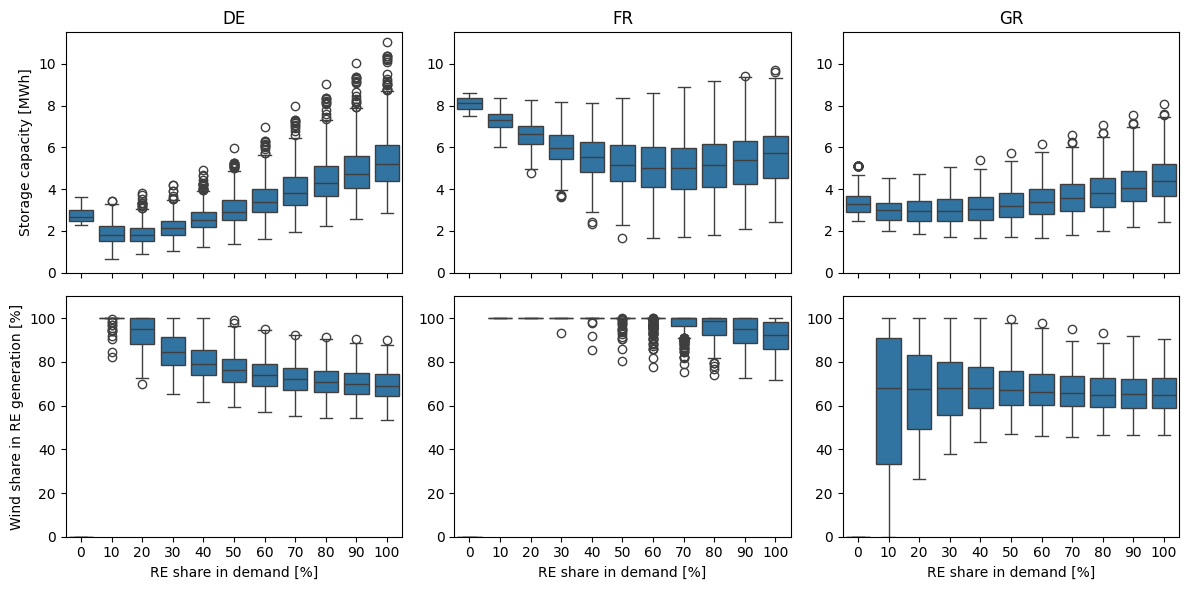

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

for i, country in enumerate(df_agg["country"].unique()):
    ax = axs[0, i]
    sns.boxplot(
        df_agg.query(f"country == '{country}'"), 
        x="renewableDemandShare",
        y="MAX_STO",
        ax=ax,
    )
    ax.set_ylim(0, 11.5)
    if i == 0:
        ax.set_ylabel("Storage capacity [MWh]")
    else:
        ax.set_ylabel("")
    
    ax.set_title(country)
    ax = axs[1, i]
    sns.boxplot(
        df_agg.query(f"country == '{country}'"), 
        x="renewableDemandShare",
        y="shareWind",
        ax=ax,
    )
    if i == 0:
        ax.set_ylabel("Wind share in RE generation [%]")
    else:
        ax.set_ylabel("")
    ax.set_ylim(0, 110)
    ax.set_xlabel("RE share in demand [%]")
plt.tight_layout()